In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy.constants as cts
import pylcp

to_deg = lambda r: 180*r/np.pi
to_rad = lambda d: np.pi*d/180

In [129]:
"""NOTE: where include_mag_forces=False, this apparently does not mean
that the magnetic forces are in fact off... the documentation says that
the unitless conventions they use only work when that parameter is False.
""";

## $^{87}$Rb 3D MOT - goofy beams

manually defined beams for network node pancake chamber chip

In [96]:
atom = pylcp.atom("87Rb")

det = -2.0
alpha = 1.0
s = 1.0


H_g_D2, mu_q_g_D2 = pylcp.hamiltonians.hyperfine_coupled(
    atom.state[0].J, atom.I, atom.state[0].gJ, atom.gI,
    atom.state[0].Ahfs/atom.state[2].gammaHz, Bhfs=0, Chfs=0,
    muB=1)
H_e_D2, mu_q_e_D2 = pylcp.hamiltonians.hyperfine_coupled(
    atom.state[2].J, atom.I, atom.state[2].gJ, atom.gI,
    Ahfs=atom.state[2].Ahfs/atom.state[2].gammaHz,
    Bhfs=atom.state[2].Bhfs/atom.state[2].gammaHz, Chfs=0,
    muB=1)
mu_q_g_D2[1]
dijq_D2 = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(
    atom.state[0].J, atom.state[2].J, atom.I)

E_e_D2 = np.unique(np.diagonal(H_e_D2))
E_g_D2 = np.unique(np.diagonal(H_g_D2))

hamiltonian_D2 = pylcp.hamiltonian(H_g_D2, H_e_D2, mu_q_g_D2, 
                                   mu_q_e_D2, dijq_D2)

# Define the laser beams:
cooling_det = (E_e_D2[-1] - E_g_D2[-1]) + det # detuned by det from F=2->F'=3
rp_det = (E_e_D2[-2] - E_g_D2[-2]) # resonant w/ F=1->F'=2

# beam unit vectors
th = to_rad(27) # half the angle between x,y beams
ph = to_rad(30) # angle between z beam and y or x plane

kx = np.array([np.cos(th), -np.sin(th), 0])
ky = np.array([np.cos(th), np.sin(th), 0])
kz = np.array([0, np.sin(ph), np.cos(ph)])

sx = 1
sy = 10
sz = 17
px = py = -1
pz = 1

laserBeams_cooling_D2 = pylcp.laserBeams(
    [
     # X
     {'kvec':kx, 's':sx, 'pol':px, 'delta':cooling_det},
     {'kvec':-kx, 's':sx, 'pol':px, 'delta':cooling_det},
     # Y
     {'kvec':ky, 's':sy, 'pol':py, 'delta':cooling_det},
     {'kvec':-ky, 's':sy, 'pol':py, 'delta':cooling_det},
     # Z
     {'kvec':kz, 's':sy, 'pol':pz, 'delta':cooling_det},
     {'kvec':-kz, 's':sy, 'pol':pz, 'delta':cooling_det}
    ],
    beam_type=pylcp.infinitePlaneWaveBeam
)
 
laserBeams_repump_D2 = pylcp.laserBeams(
    [
     # X
     {'kvec':kx, 's':.01*sx, 'pol':px, 'delta':rp_det},
     {'kvec':-kx, 's':.01*sx, 'pol':px, 'delta':rp_det},
     # Y
     {'kvec':ky, 's':.01*sy, 'pol':py, 'delta':rp_det},
     {'kvec':-ky, 's':.01*sy, 'pol':py, 'delta':rp_det},
     # Z
     {'kvec':kz, 's':.01*sz, 'pol':pz, 'delta':rp_det},
     {'kvec':-kz, 's':.01*sz, 'pol':pz, 'delta':rp_det}
    ],
    beam_type=pylcp.infinitePlaneWaveBeam
)
    
laserBeams_D2 = laserBeams_cooling_D2 + laserBeams_repump_D2

magField = pylcp.quadrupoleMagneticField(alpha)

In [97]:
"""Construct the full rate equations for the D2 line:"""

x = np.arange(-5, 5.1, 0.2)
v = np.arange(-5, 5.1, 0.2)

dx = np.mean(np.diff(x))
dv = np.mean(np.diff(v))

X, V = np.meshgrid(x, v)

trap_D2 = pylcp.rateeq(
    laserBeams_D2, magField, hamiltonian_D2, include_mag_forces=False)
trap_D2.generate_force_profile(
#     [np.zeros(X.shape), np.zeros(X.shape), X],
#     [np.zeros(V.shape), np.zeros(V.shape), V],
    [X, X, X],
    [V, V, V],
     progress_bar=True)

Completed in 6.88 s.                                               


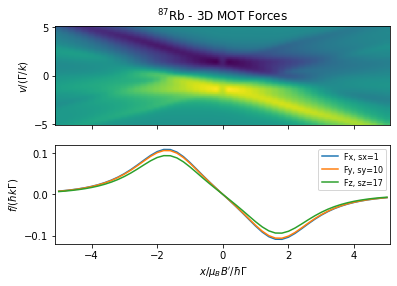

In [98]:
"""Plot the results"""

force = trap_D2.profile['0'].F

fig, ax = plt.subplots(2, 1, sharex=True)#, figsize=(1.5*3.25, 1.5*2.75))
ax[0].imshow(force[2], origin='lower',
               extent=(np.amin(x)-dx/2, np.amax(x)+dx/2,
                       np.amin(v)-dv/2, np.amax(v)+dv/2),
               aspect='auto')

for f,l in zip(force,[f'Fx, sx={sx}',f'Fy, sy={sy}',f'Fz, sz={sz}']):
    ax[1].plot(X[int(X.shape[0]/2), :],
              f[int(X.shape[0]/2), :],label=l)

ax[1].legend(fontsize=8)

# [ax[ii, 1].yaxis.set_ticklabels('') for ii in range(2)]
# [ax[0, ii].xaxis.set_ticklabels('') for ii in range(2)]

ax[0].set_title('$^{87}$Rb - 3D MOT Forces')
ax[0].set_ylabel('$v/(\Gamma/k)$')
ax[1].set_ylabel('$f/(\hbar k \Gamma)$')
ax[1].set_xlabel('$x/\mu_B B\'/\hbar\Gamma$');
# ax[1, 1].set_xlabel('$x/\mu_B B\'/\hbar\Gamma$');

fname = f"3d_rb87_mot_forces_ZinZY_th{int(to_deg(th))}_ph{int(to_deg(ph))}_sx{sx}_sy{sy}_sz{sz}_px{px}_py{py}_pz{pz}.png"
fname
plt.savefig(fname, bbox_inches='tight')

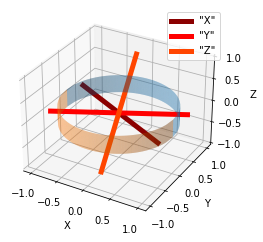

In [79]:
# the beams
fig = plt.figure()
ax = plt.axes(projection='3d')

for k,l,c in zip([kx,ky,kz],['"X"','"Y"','"Z"'],['darkred','red','orangered']):
    u = k/max(k)
    pts = np.linspace(-1,1,2)
    xdata = u[0]*pts
    ydata = u[1]*pts
    zdata = u[2]*pts
    ax.plot3D(xdata, ydata, zdata, c=c, label=l, linewidth=5)
    
# Cylinder
x=np.linspace(-1, 1, 100)
z=np.linspace(-.2, .2, 100)
Xc, Zc=np.meshgrid(x, z)
Yc = np.sqrt(1-Xc**2)


# Draw parameters
rstride = 10

ax.plot_surface(Xc, Yc, Zc, alpha=0.5)#, rstride=rstride, cstride=cstride)
ax.plot_surface(Xc, -Yc, Zc, alpha=0.5)#, rstride=rstride, cstride=cstride)    
# ax.plot_surface()

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()

fname = f"3d_mot_beams_th{int(to_deg(th))}_ZinYZ_ph{int(to_deg(ph))}.png"
plt.savefig(fname, bbox_inches='tight')

In [49]:
kx,ky,kz

(array([ 0.89100652, -0.4539905 ,  0.        ]),
 array([0.89100652, 0.4539905 , 0.        ]),
 array([0.5      , 0.       , 0.8660254]))